In [1]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pandas as pd
from scipy import stats
import math
import theano
import theano.tensor as tt
from theano import shared
import pymc3 as pm

# Helper functions

In [2]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def normalize(x):
    return x/np.sum(x)

def rmse(pred, actual):
    return math.sqrt(np.mean((pred-actual)**2))

def sort_category(unique, count):
    output = np.ones(3) - 1
    for i in range(3):
        for j in range(len(unique)):
            if(i==unique[j]):
                output[i]=count[j]
    return normalize(output) 

def perturb(x, noise=.001):
    return tt.switch(tt.ge(x,1),1-noise, tt.switch(tt.le(x,0), noise, x))

def compute_ci_discrete(x, HDI, n, sim):
    output = [None]*sim
    for i in range(sim):
        draw = np.random.choice(x, size = n, replace = True)
        unique, counts = np.unique(draw, return_counts=True)
        output[i] = sort_category(unique, counts)
    lower = np.ones(len(output[0]))
    upper = np.ones(len(output[0]))
    output = np.transpose(output) # each element is now all the samples of one category
    for i in range(len(output)):
        lower[i] = np.quantile(output[i], q = (1-HDI)/2)
        upper[i] = np.quantile(output[i], q = 1-(1-HDI)/2)
    return [lower, upper]

def compute_ci_continuous(x, HDI, n, sim):
    output = np.ones(sim)
    for i in range(sim):
        draw = np.random.choice(x, size = n, replace = True)
        output[i] = np.mean(draw)
    lower = np.quantile(output, q = (1-HDI)/2)
    upper = np.quantile(output, q = 1-(1-HDI)/2)
    return [lower, upper]

def computeA(m, s):
    return (m*s)/(1-m)

# Computational models for mutiple-causes scenario

## Data preprocessing

In [3]:
data = pd.read_csv('ecl_dat.csv', encoding="ISO-8859-1")
emotion = data.loc[data['condition'] == 'condition 1']
noemotion = data.loc[data['condition'] == 'condition 2']

### Computing means for causal inference

In [4]:
world1human_emotion = np.array(emotion["relationBlueNorm"])
world2human_emotion = np.array(emotion["relationOrangeNorm"])
world3human_emotion = np.array(emotion["relationOrangeBlueNorm"])
worldhuman_emotion = sort_category([0,1,2],[np.mean(world1human_emotion),np.mean(world2human_emotion),np.mean(world3human_emotion)])

world1human_noemotion = np.array(noemotion["relationBlueNorm"]) 
world2human_noemotion = np.array(noemotion["relationOrangeNorm"]) 
world3human_noemotion = np.array(noemotion["relationOrangeBlueNorm"])
worldhuman_noemotion = sort_category([0,1,2],[np.mean(world1human_noemotion),np.mean(world2human_noemotion),np.mean(world3human_noemotion)])

### Computing means for belief inference

In [5]:
belief1human_emotion = np.array(emotion["expBlueNorm"]) 
belief2human_emotion = np.array(emotion["expOrangeNorm"]) 
belief3human_emotion = np.array(emotion["expBothNorm"]) 
beliefhuman_emotion = sort_category([0,1,2],[np.mean(belief1human_emotion),np.mean(belief2human_emotion),np.mean(belief3human_emotion)])

belief1human_noemotion = np.array(noemotion["expBlueNorm"]) 
belief2human_noemotion = np.array(noemotion["expOrangeNorm"]) 
belief3human_noemotion = np.array(noemotion["expBothNorm"]) 
beliefhuman_noemotion = sort_category([0,1,2],[np.mean(belief1human_noemotion),np.mean(belief2human_noemotion),np.mean(belief3human_noemotion)])

### Computing means for knowledge and desire inference

In [6]:
knowledgehuman_emotion = (np.array(emotion["knowledge1"])-1)/8
desirehuman_emotion = (np.array(emotion["desire"])-1)/8

In [7]:
knowledgehuman_noemotion = (np.array(noemotion["knowledge1"])-1)/8
desirehuman_noemotion = (np.array(noemotion["desire"])-1)/8

## Model (for the condition with no emotional display)

In [8]:
# These parameters are fixed across both conditions (emotions and no-emotions)
# A noise parameter which controls how much randomness is added at each conditional sampling (e.g., drawing actions from belief and desire) was allowed to vary across both conditions

# The model assumes that people perceive others to have high knowledgability.
# We simulated this using a beta distribution with a = 5 and b = 2 (mean of .71).
a = 5
b = 2

d = .5 # fixed prior for desire
delay = .2 # probability that first action had a delayed effect
human_prior = [0.3816152,0.3063088,0.3120760]

In [9]:
np.random.seed(123456)

In [10]:
with pm.Model() as model1:
    # the noise parameter affects the amount of randomness included into the sampling process. 
    # For example, a person's actions might sometimes be incongruent to his intentions and event relationships can be noisy
    # we set a higher noise parameter for the no-emotion condition as this led to slightly better model fit
    # however, even when we fixed the noise for both models, the overall inference patterns remained qualitatively similar
    noise = .25
    world = pm.Categorical("world", [human_prior], shape=(1)) # blue, orange, both
    knowledge_p = pm.Beta("knowledge_p", a, b, shape=(1)) # reliability of the agent's knowledge
    knowledge = pm.Binomial("knowledge", 1, knowledge_p, shape=(1))
    
    belief1_random = pm.Categorical("belief1_random", [1,1,1], shape=(1)) # blue, orange, both
    belief1 = pm.Deterministic("belief1", knowledge*world + (1-knowledge)*belief1_random)
    
    desire = pm.Binomial("desire", 1, d, shape=(1)) # desire bulb to turn on=1, others=0

    action1_blue_p = pm.Deterministic("action1_blue_p", tt.eq(belief1,0)*desire*(1-noise) + \
                                      # if believe both are needed,
                                      tt.eq(belief1,2)*desire*(1-noise) + \
                                      # mistaken action
                                      tt.eq(belief1,1)*desire*noise +\
                                      # if desire something else
                                      (1-desire)*noise)
    action1_blue_p = perturb(action1_blue_p) # perturb ensures that the probability is not equals to 1 or 0
    
    action1_orange_p = pm.Deterministic("action1_orange_p", tt.eq(belief1,1)*desire*(1-noise) + \
                                        # if believe both are needed,
                                        tt.eq(belief1,2)*desire*(1-noise) + \
                                        # mistaken action
                                        tt.eq(belief1,0)*desire*noise +\
                                        # if desire something else,
                                        (1-desire)*noise)
    action1_orange_p = perturb(action1_orange_p) # perturb ensures that the probability is not equals to 1 or 0
    
    action1_stack = tt.transpose(tt.stack(action1_blue_p,action1_orange_p,[noise*2]))
    action1 = pm.Categorical("action1",action1_stack,observed=0,shape=(1)) # blue orange others
    
    outcome1_p = pm.Deterministic("outcome1_p", tt.eq(world,0)*tt.eq(action1,0)*(1-delay) + \
                                  tt.eq(world,1)*tt.eq(action1,1)*(1-delay) + \
                                  # if both boxes are required, then outcome will likely not happen
                                  tt.eq(world,2)*0)
    outcome1_p = perturb(outcome1_p,noise) # add noise to outcome when probability is 1 or 0
    
    outcome1 = pm.Binomial("outcome1", 1, outcome1_p, observed = 0 , shape = (1))
    
    happy1 = outcome1*desire*(1-noise) + noise*(1-desire)
    # if agent believes both actions are needed, they likely won't be frustrated at the lack of an outcome
    frustrated1 = (1-outcome1)*desire*tt.neq(belief1, 2)*(1-noise) + (1-outcome1)*desire*tt.eq(belief1, 2)*noise + noise*(1-desire)
    neutral1 = [1]
    emotion_array1 = tt.transpose(tt.stack(happy1, frustrated1, neutral1 ))
    expression1 = pm.Categorical("expression1",emotion_array1,observed=2 ) # happy, frustrated, neutral

    # if frustrated, agent is likely to revise belief
    # else stick to previous belief
    belief2_random = pm.Categorical("belief2_random", [1,1,1], shape=(1))
    belief2 = pm.Deterministic("belief2", tt.eq(expression1,1)*belief2_random + \
                              tt.neq(expression1,1)*belief1)
    
    # if outcome has been reached (and agent desired outcome), then likely no action would follow 
    action2_blue_p = pm.Deterministic("action2_blue_p", tt.switch(tt.eq(outcome1,0)*desire, \
                                                                  tt.eq(belief2,0)*(1-noise) + \
                                                                  # if believe both are needed and orange was pushed previously, then push blue
                                                                  tt.eq(belief2,2)*tt.eq(action1,1)*(1-noise)+ \
                                                                  # mistaken action
                                                                  tt.eq(belief2,1)*noise,
                                                                  # if outcome was reached at t1, no further action required
                                                                  noise)) 
    action2_blue_p = perturb(action2_blue_p)
    
    # if outcome has been reached (and agent desired outcome), then likely no action would follow 
    action2_orange_p = pm.Deterministic("action2_orange_p", tt.switch(tt.eq(outcome1,0)*desire, \
                                                                  tt.eq(belief2,1)*(1-noise) + \
                                                                  # if believe both are needed and blue was pushed previously, then push orange 
                                                                  tt.eq(belief2,2)*tt.eq(action1,0)*(1-noise)+ \
                                                                  # mistaken action
                                                                  tt.eq(belief2,0)*noise,
                                                                  noise)) 
    action2_orange_p = perturb(action2_orange_p)
    action2_stack = tt.transpose(tt.stack(action2_blue_p, action2_orange_p, [noise*2]))
    action2 = pm.Categorical("action2", action2_stack, observed=1, shape=(1)) # blue orange others
    
    outcome2_p = pm.Deterministic("outcome2_p", tt.eq(world,0)*tt.eq(action2,0) + \
                                  # if previous action has a delayed effect
                                  tt.eq(world,0)*tt.eq(action1,0)*tt.neq(action2,0)*delay + \
                                  tt.eq(world,1)*tt.eq(action2,1) + \
                                  # if previous action has a delayed effect
                                  tt.eq(world,1)*tt.eq(action1,1)*tt.neq(action2,1)*delay + \
                                  tt.eq(world,2)*tt.eq(action1,0)*tt.eq(action2,1)+ \
                                  tt.eq(world,2)*tt.eq(action1,1)*tt.eq(action2,0)) 
    outcome2_p = perturb(outcome2_p, noise)
    outcome2 = pm.Binomial("outcome2", 1, outcome2_p, observed = 1, shape = (1))
    
    happy2 = outcome2*desire*(1-noise) + noise*(1-desire)
    frustrated2 = (1-outcome2)*desire*(1-noise) + noise*(1-desire)
    neutral2 = [1]
    emotion_array2 = tt.transpose(tt.stack(happy2, frustrated2, neutral2 ))
    expression2 = pm.Categorical("expression2",emotion_array2,observed=2 ) # happy, frustrated, neutral
    
    draw = 2000 
    trace1 = pm.sample(draw, tune=1000, chains=4, return_inferencedata=False)
    
    
# note: we compute the RMSE for reference (also useful to compare between models)
# Conceptually, however, it might be difficult to compare these predictions one-to-one as normalized human ratings is not the same as probability
unique, counts = np.unique(trace1["world"], return_counts=True)
worldposterior = sort_category(unique, counts)
world_rmse = rmse(worldposterior, worldhuman_noemotion)
print(world_rmse)
unique, counts = np.unique(trace1["belief1"], return_counts=True)
belief1posterior = sort_category(unique, counts)
belief_rmse = rmse(belief1posterior, beliefhuman_noemotion)
print(belief_rmse)
desireposterior = np.mean(trace1["desire"])
desire_rmse = rmse(desireposterior, desirehuman_noemotion)
print(desire_rmse)
knowledgeposterior = np.mean(trace1["knowledge"])
knowledge_rmse = rmse(knowledgeposterior, knowledgehuman_noemotion)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [belief2_random, belief1_random, world]
>NUTS: [knowledge_p]
>CompoundStep
>>Metropolis: [desire]
>>Metropolis: [knowledge]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


0.14042544609758603
0.1844637444322516
0.26036078465463186


### Summary statistics

In [11]:
unique, counts = np.unique(trace1["world"], return_counts=True)
print("world: " + str(dict(zip(unique, counts))))
print(sort_category(unique, counts))

print("knowledge p: " + str(np.mean(trace1["knowledge_p"])))
unique, counts = np.unique(trace1["knowledge"], return_counts=True)
print("knowledge: " + str(np.mean(trace1["knowledge"])))

unique, counts = np.unique(trace1["belief1"], return_counts=True)
print("belief1: " + str(dict(zip(unique, counts))))
print(sort_category(unique, counts))

unique, counts = np.unique(trace1["belief2"], return_counts=True)
print("belief2: " + str(dict(zip(unique, counts))))
print(sort_category(unique, counts))

unique, counts = np.unique(trace1["desire"], return_counts=True)
print("desire: " + str(np.mean(trace1["desire"])))

world: {0: 213, 1: 2601, 2: 5186}
[0.026625 0.325125 0.64825 ]
knowledge p: 0.7280871291408783
knowledge: 0.7735
belief1: {0: 573, 1: 2156, 2: 5271}
[0.071625 0.2695   0.658875]
belief2: {0: 573, 1: 2156, 2: 5271}
[0.071625 0.2695   0.658875]
desire: 0.675625


### Confidence intervals

In [12]:
np.random.seed(123456)
print("world :" + str(compute_ci_discrete(flatten(trace1["world"]), HDI = .95, n = 1000, sim = 1000))) #70
print("knowledge :" + str(compute_ci_continuous(flatten(trace1["knowledge_p"]), HDI = .95, n = 70, sim = 1000)))
print("belief1 :" + str(compute_ci_discrete(flatten(trace1["belief1"]), HDI = .95, n =1000, sim = 1000)))
print("belief2 :" + str(compute_ci_discrete(flatten(trace1["belief2"]), HDI = .95, n = 1000, sim = 1000)))
print("desire :" + str(compute_ci_continuous(flatten(trace1["desire"]), HDI = .95, n = 70, sim = 1000)))

world :[array([0.017   , 0.295975, 0.619   ]), array([0.037, 0.353, 0.678])]
knowledge :[0.6910276916605318, 0.7660987882539095]
belief1 :[array([0.056   , 0.241   , 0.629975]), array([0.09    , 0.297   , 0.687025])]
belief2 :[array([0.056, 0.244, 0.629]), array([0.088, 0.296, 0.686])]
desire :[0.5571428571428572, 0.7857142857142857]


/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'world'}>,
        <AxesSubplot:title={'center':'world'}>],
       [<AxesSubplot:title={'center':'knowledge'}>,
        <AxesSubplot:title={'center':'knowledge'}>],
       [<AxesSubplot:title={'center':'belief1_random'}>,
        <AxesSubplot:title={'center':'belief1_random'}>],
       [<AxesSubplot:title={'center':'desire'}>,
        <AxesSubplot:title={'center':'desire'}>],
       [<AxesSubplot:title={'center':'belief2_random'}>,
        <AxesSubplot:title={'center':'belief2_random'}>],
       [<AxesSubplot:title={'center':'knowledge_p'}>,
        <AxesSubplot:title={'center':'knowledge_p'}>],
       [<AxesSubplot:title={'center':'belief1'}>,
        <AxesSubplot:title={'center':'belief1'}>],
       [<AxesSubplot:title={'center':'action1_blue_p'}>,
        <AxesSubplot:title={'center':'action1_blue_p'}>],
       [<AxesSubplot:title={'center':'action1_orange_p'}>,
        <AxesSubplot:title={'center':'action1_orange_p'}>],
       [<AxesSubplot:titl

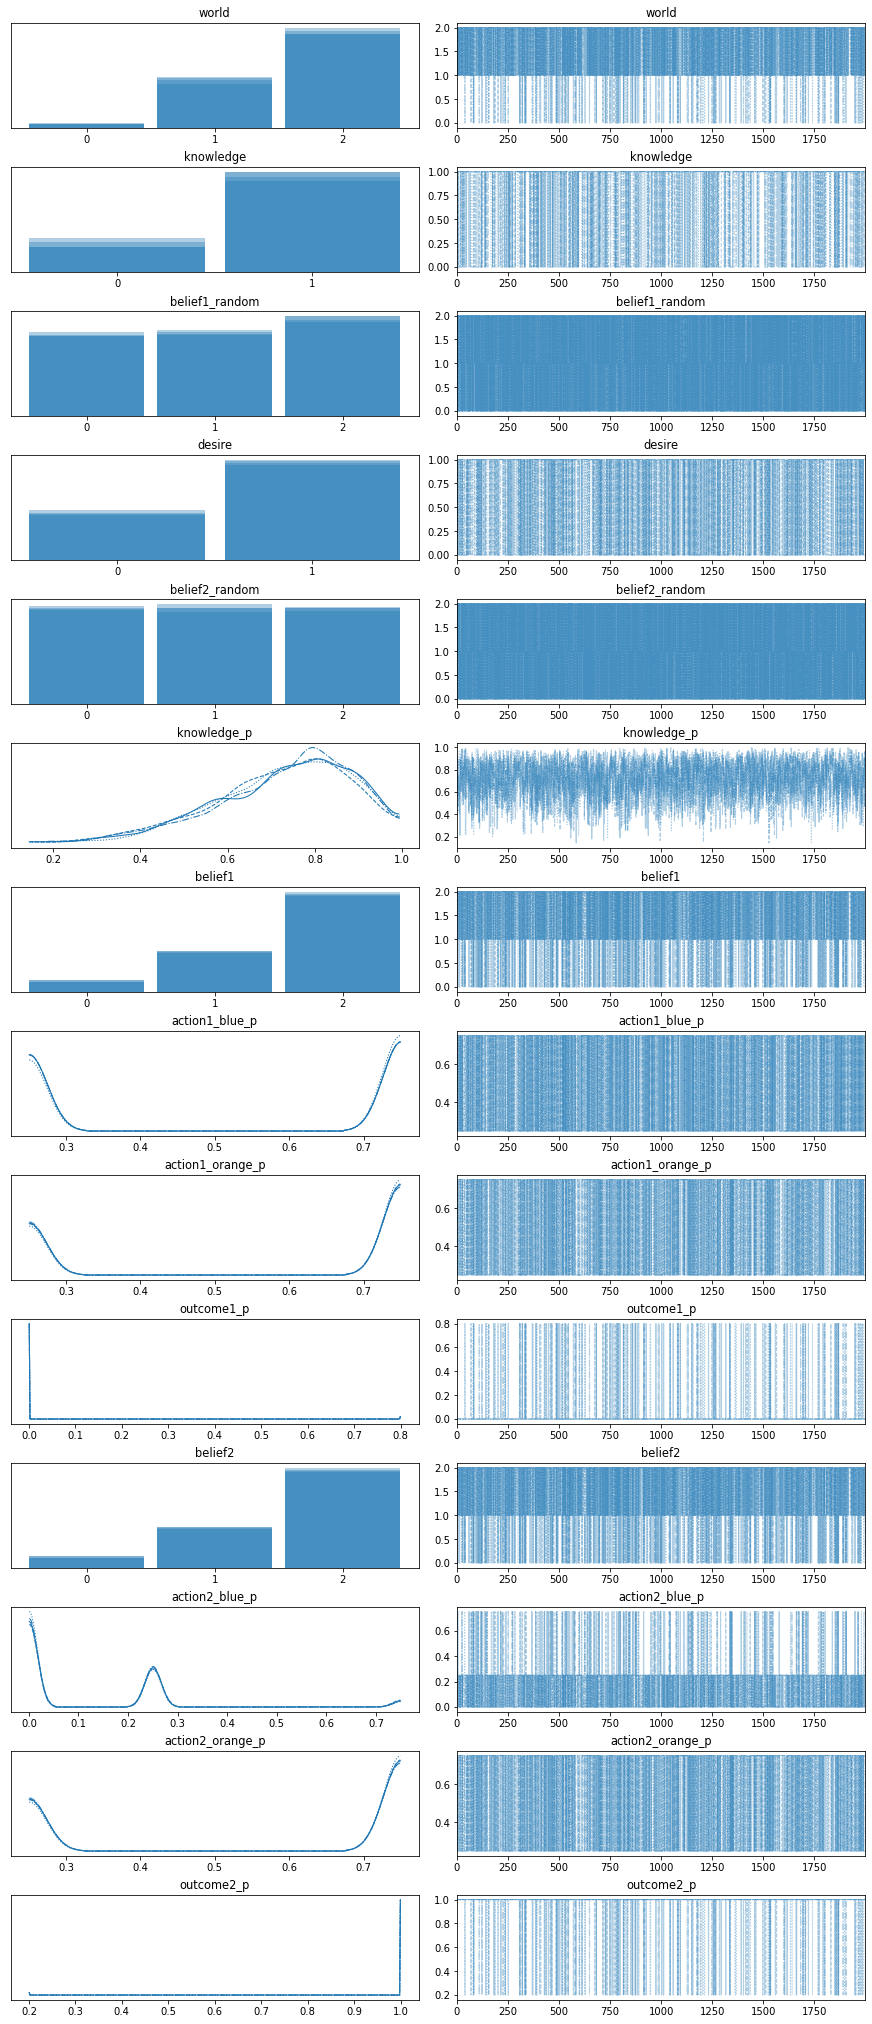

In [13]:
az.plot_trace(trace1)

## Model (for the condition with emotional displays)

In [14]:
np.random.seed(123456)

In [15]:
with pm.Model() as model2:
    noise = .25
    world = pm.Categorical("world", [human_prior], shape=(1)) # blue, orange, both
    knowledge_p = pm.Beta("knowledge_p", a, b, shape=(1)) # reliability of the agent's knowledge
    knowledge = pm.Binomial("knowledge", 1, knowledge_p, shape=(1))
    
    belief1_random = pm.Categorical("belief1_random", [1,1,1], shape=(1))
    belief1 = pm.Deterministic("belief1", knowledge*world + (1-knowledge)*belief1_random)
    
    desire = pm.Binomial("desire",1, d, shape=(1)) # desire bulb to turn on=1, others=0

    action1_blue_p = pm.Deterministic("action1_blue_p", tt.eq(belief1,0)*desire*(1-noise) + \
                                      # if believe both are needed,
                                      tt.eq(belief1,2)*desire*(1-noise) + \
                                      # mistaken action
                                      tt.eq(belief1,1)*desire*noise +\
                                      # if desire something else
                                      (1-desire)*noise)
    action1_blue_p = perturb(action1_blue_p) # perturb ensures that the probability is not equals to 1 or 0
    
    action1_orange_p = pm.Deterministic("action1_orange_p", tt.eq(belief1,1)*desire*(1-noise) + \
                                        # if believe both are needed,
                                        tt.eq(belief1,2)*desire*(1-noise) + \
                                        # mistaken action
                                        tt.eq(belief1,0)*desire*noise +\
                                        # if desire something else,
                                        (1-desire)*noise)
    action1_orange_p = perturb(action1_orange_p) # perturb ensures that the probability is not equals to 1 or 0
    
    action1_stack = tt.transpose(tt.stack(action1_blue_p,action1_orange_p,[noise*2]))
    action1 = pm.Categorical("action1",action1_stack,observed=0,shape=(1)) # blue orange others
    
    outcome1_p = pm.Deterministic("outcome1_p", tt.eq(world,0)*tt.eq(action1,0)*(1-delay) + \
                                  tt.eq(world,1)*tt.eq(action1,1)*(1-delay) + \
                                  # if both boxes are required, then outcome will likely not happen
                                  tt.eq(world,2)*0)
    outcome1_p = perturb(outcome1_p,noise) # add noise to outcome
    
    outcome1 = pm.Binomial("outcome1", 1, outcome1_p, observed = 0 , shape = (1))
    
    happy1 = outcome1*desire*(1-noise) + noise*(1-desire)
    # if agent believes both actions are needed, they won't be frustrated at the lack of an outcome
    frustrated1 = (1-outcome1)*desire*tt.neq(belief1, 2)*(1-noise) + (1-outcome1)*desire*tt.eq(belief1, 2)*noise + noise*(1-desire)
    neutral1 = [1]
    emotion_array1 = tt.transpose(tt.stack(happy1, frustrated1, neutral1 ))
    expression1 = pm.Categorical("expression1",emotion_array1,observed=1 ) # happy, frustrated, neutral

    # if frustrated, agent is likely to revise belief
    # else stick to previous belief
    belief2_random = pm.Categorical("belief2_random", [1,1,1], shape=(1))
    belief2 = pm.Deterministic("belief2", tt.eq(expression1,1)*belief2_random + \
                              tt.neq(expression1,1)*belief1)
    
    # if outcome has been reached (and agent desired outcome), then likely no action would follow 
    action2_blue_p = pm.Deterministic("action2_blue_p", tt.switch(tt.eq(outcome1,0)*desire, \
                                                                  tt.eq(belief2,0)*(1-noise) + \
                                                                  # if belief both are needed and orange was pushed previously, then push blue
                                                                  tt.eq(belief2,2)*tt.eq(action1,1)*(1-noise)+ \
                                                                  # mistaken action
                                                                  tt.eq(belief2,1)*noise,
                                                                  # if outcome was reached at t1, no further action required
                                                                  noise)) 
    action2_blue_p = perturb(action2_blue_p)
    
    # if outcome has been reached (and agent desired outcome), then likely no action would follow 
    action2_orange_p = pm.Deterministic("action2_orange_p", tt.switch(tt.eq(outcome1,0)*desire, \
                                                                  tt.eq(belief2,1)*(1-noise) + \
                                                                  # if believe both are needed and blue was pushed previously, then push orange 
                                                                  tt.eq(belief2,2)*tt.eq(action1,0)*(1-noise)+ \
                                                                  # mistaken action
                                                                  tt.eq(belief2,0)*noise,
                                                                  noise)) 
    action2_orange_p = perturb(action2_orange_p)
    action2_stack = tt.transpose(tt.stack(action2_blue_p, action2_orange_p, [noise*2]))
    action2 = pm.Categorical("action2", action2_stack, observed=1, shape=(1)) # blue orange others
    
    outcome2_p = pm.Deterministic("outcome2_p", tt.eq(world,0)*tt.eq(action2,0) + \
                                  # if previous action has a delayed effect
                                  tt.eq(world,0)*tt.eq(action1,0)*tt.neq(action2,0)*delay + \
                                  tt.eq(world,1)*tt.eq(action2,1)+ \
                                  # if previous action has a delayed effect
                                  tt.eq(world,1)*tt.eq(action1,1)*tt.neq(action2,1)*delay + \
                                  tt.eq(world,2)*tt.eq(action1,0)*tt.eq(action2,1)+ \
                                  tt.eq(world,2)*tt.eq(action1,1)*tt.eq(action2,0)) 
    outcome2_p = perturb(outcome2_p, noise)
    outcome2 = pm.Binomial("outcome2", 1, outcome2_p, observed = 1, shape = (1))
    
    happy2 = outcome2*desire*(1-noise) + noise*(1-desire)
    frustrated2 = (1-outcome2)*desire*(1-noise) + noise*(1-desire)
    neutral2 = [1]
    emotion_array2 = tt.transpose(tt.stack(happy2, frustrated2, neutral2 ))
    expression2 = pm.Categorical("expression2",emotion_array2,observed=0 ) # happy, frustrated, neutral
    
    draw = 2000 
    trace2 = pm.sample(draw, tune=1000, chains=4, return_inferencedata=False)
    
# note: we compute the RMSE for reference (also useful to compare between models)
# Conceptually, however, it might be difficult to compare these predictions one-to-one as normalized human ratings is not the same as probability
unique, counts = np.unique(trace2["world"], return_counts=True)
worldposterior = sort_category(unique, counts)
world_rmse = rmse(worldposterior, worldhuman_emotion)
print(world_rmse)
unique, counts = np.unique(trace2["belief1"], return_counts=True)
belief1posterior = sort_category(unique, counts)
belief_rmse = rmse(belief1posterior, beliefhuman_emotion)
print(belief_rmse)
desireposterior = np.mean(trace2["desire"])
desire_rmse = rmse(desireposterior, desirehuman_emotion)
print(desire_rmse)
knowledgeposterior = np.mean(trace2["knowledge"])
knowledge_rmse = rmse(knowledgeposterior, knowledgehuman_emotion)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [belief2_random, belief1_random, world]
>NUTS: [knowledge_p]
>CompoundStep
>>Metropolis: [desire]
>>Metropolis: [knowledge]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


0.06515851046758213
0.08552424652373931
0.18028577460885756


### Summary statistics

In [16]:
unique, counts = np.unique(trace2["world"], return_counts=True)
print("world: " + str(dict(zip(unique, counts))))
print(sort_category(unique,counts))
print("knowledge p: " + str(np.mean(trace2["knowledge_p"])))
print("knowledge: " + str(np.mean(trace2["knowledge"])))
unique, counts = np.unique(trace2["belief1"], return_counts=True)
print("belief1: " + str(dict(zip(unique, counts))))
print(sort_category(unique,counts))
unique, counts = np.unique(trace2["belief2"], return_counts=True)
print("belief2: " + str(dict(zip(unique, counts))))
print(sort_category(unique,counts))
unique, counts = np.unique(trace2["desire"], return_counts=True)
print("desire: " + str(np.mean(trace2["desire"])))

world: {0: 633, 1: 3603, 2: 3764}
[0.079125 0.450375 0.4705  ]
knowledge p: 0.7010684020851761
knowledge: 0.613375
belief1: {0: 2213, 1: 2806, 2: 2981}
[0.276625 0.35075  0.372625]
belief2: {0: 1204, 1: 3124, 2: 3672}
[0.1505 0.3905 0.459 ]
desire: 0.89


### Confidence intervals

In [17]:
np.random.seed(123456)
print("world :" + str(compute_ci_discrete(flatten(trace2["world"]), HDI = .95, n = 1000, sim = 1000)))
print("knowledge :" + str(compute_ci_continuous(flatten(trace2["knowledge_p"]), HDI = .95, n = 59, sim = 1000)))
print("belief1 :" + str(compute_ci_discrete(flatten(trace2["belief1"]), HDI = .95, n = 1000, sim = 1000)))
print("belief2 :" + str(compute_ci_discrete(flatten(trace2["belief2"]), HDI = .95, n = 1000, sim = 1000)))
print("desire :" + str(compute_ci_continuous(flatten(trace2["desire"]), HDI = .95, n = 59, sim = 1000)))

world :[array([0.063   , 0.42    , 0.439975]), array([0.096025, 0.483   , 0.5     ])]
knowledge :[0.6590772007285087, 0.742396001297825]
belief1 :[array([0.249, 0.322, 0.342]), array([0.303, 0.381, 0.402])]
belief2 :[array([0.13    , 0.360975, 0.43    ]), array([0.172, 0.422, 0.49 ])]
desire :[0.8135593220338984, 0.9661016949152542]


/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'world'}>,
        <AxesSubplot:title={'center':'world'}>],
       [<AxesSubplot:title={'center':'knowledge'}>,
        <AxesSubplot:title={'center':'knowledge'}>],
       [<AxesSubplot:title={'center':'belief1_random'}>,
        <AxesSubplot:title={'center':'belief1_random'}>],
       [<AxesSubplot:title={'center':'desire'}>,
        <AxesSubplot:title={'center':'desire'}>],
       [<AxesSubplot:title={'center':'belief2_random'}>,
        <AxesSubplot:title={'center':'belief2_random'}>],
       [<AxesSubplot:title={'center':'knowledge_p'}>,
        <AxesSubplot:title={'center':'knowledge_p'}>],
       [<AxesSubplot:title={'center':'belief1'}>,
        <AxesSubplot:title={'center':'belief1'}>],
       [<AxesSubplot:title={'center':'action1_blue_p'}>,
        <AxesSubplot:title={'center':'action1_blue_p'}>],
       [<AxesSubplot:title={'center':'action1_orange_p'}>,
        <AxesSubplot:title={'center':'action1_orange_p'}>],
       [<AxesSubplot:titl

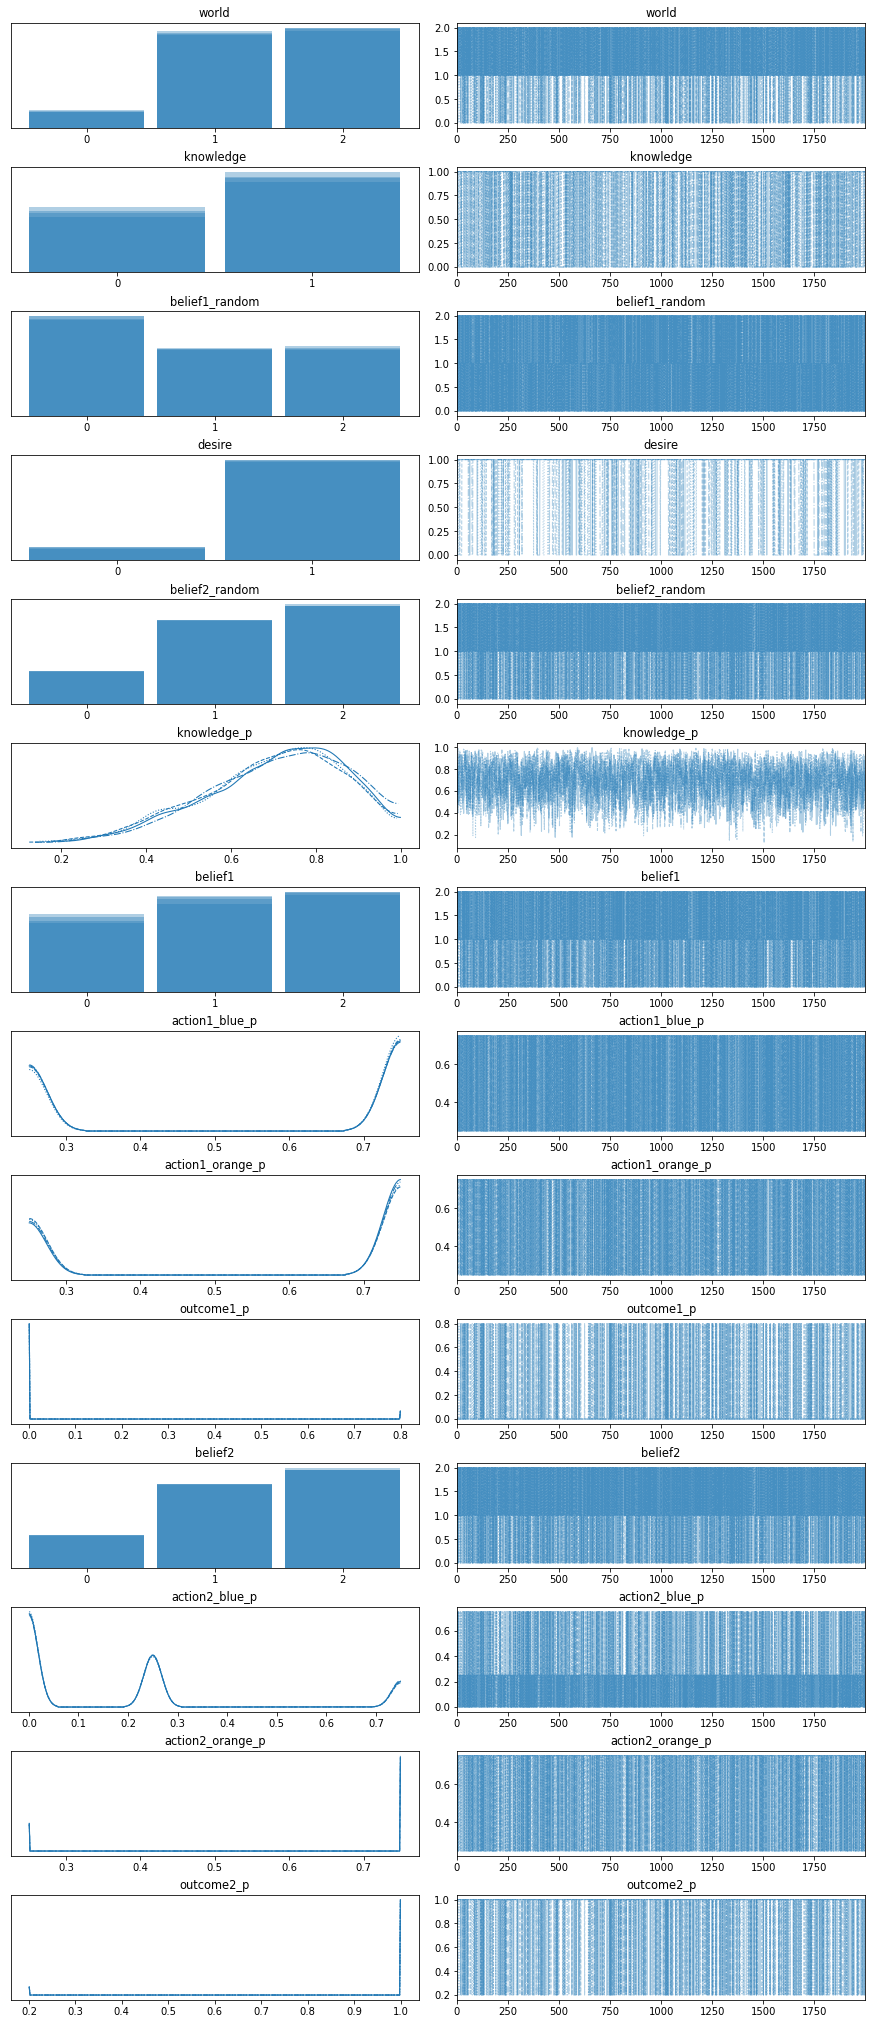

In [18]:
az.plot_trace(trace2)